In [7]:
import numpy as np
import pandas as pd
import zipfile as zp
from pathlib import Path
from gensim.utils import check_output
from sklearn.preprocessing import normalize
from scipy.special import softmax
import shutil
from subprocess import check_output
import torch
from tqdm import tqdm
import colored
import itertools
import matplotlib.pyplot as plt
from scipy.special import softmax
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams.update({'font.size': 16})


In [2]:
def printgr(text):
    print(colored.stylize(text, colored.fg('green')))

In [2]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

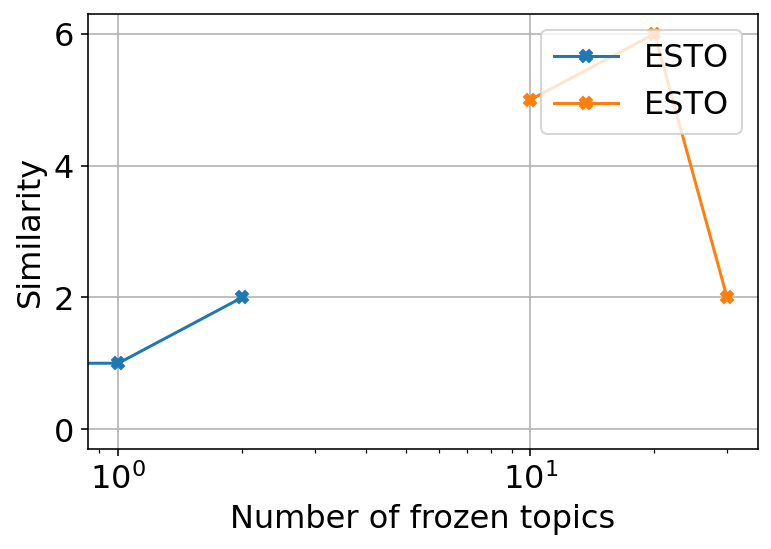

In [10]:
plt.semilogx([0,1,2], [0,1,2], label = "ESTO", marker="X")
plt.semilogx([10,20,30], [5,6,2], label = "ESTO", marker="X")
plt.xlabel('Number of frozen topics', fontsize=16)
plt.ylabel('Similarity', fontsize=16)
plt.legend(loc="upper right")
plt.grid()
plt.show()

In [4]:
#cd /export/usuarios_ml4ds/lbartolome/topicmodeler

In [5]:
#from src.topicmodeling.neural_models.pytorchavitm.datasets.bow_dataset import BOWDataset
#from src.topicmodeling.neural_models.pytorchavitm.avitm_network.avitm import AVITM
#from src.topicmodeling.neural_models.pytorchavitm.utils.data_preparation import prepare_dataset

In [6]:
modelsdir = Path("/export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test")

In [7]:
!git clone https://github.com/MIND-Lab/OCTIS.git

fatal: destination path 'OCTIS' already exists and is not an empty directory.


In [8]:
cd OCTIS

/export/usuarios_ml4ds/lbartolome/topicmodeler/aux/federated/OCTIS


In [9]:
from octis.models.pytorchavitm.avitm import avitm_model as AVITM

In [10]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#from octis.models.pytorchavitm.datasets.bow import BOWDataset

import torch
from torch.utils.data import Dataset


class BOWDataset(Dataset):
    
    """Class to load BOW dataset."""

    def __init__(self, X, idx2token):

        """
        Initializes BOWDataset.

        Parameters
        ----------
        X : array-like, shape=(n_samples, n_features)
            Document-term matrix
        idx2token : list
            A list of feature names
        """
        self.X = X
        self.idx2token = idx2token

    def __len__(self):
        """Returns length of dataset."""
        return len(self.X)

    def __getitem__(self, i):
        """Returns sample from dataset at index i."""
        X = torch.FloatTensor(self.X[i])

        return {'X': X}

def prepare_dataset(corpus, val_size=0.25):
    """It prepares the training data in the format that is asked as input in AVITM.

    Parameters
    ----------
    corpus: List[str]
        List of documents to be used for training of the model
    val_size: float (default=0.25)
        Percentage of the documents to be used for validation

    Returns
    -------
    train_data: BOWDataset
        Training dataset in the required format for AVITM
    val_data: BOWDataset
        Validation dataset in the required format for AVITM
    input_size: int
        Size of the input dimensions of the AVITM model to be trained
    id2token: tuple
        Mappings with the content of each training dataset's document-term matrix.

    """

    # Divide data into training and validation
    docs_train, docs_val = train_test_split(corpus, test_size=val_size, random_state=42)

    # Create a CountVectorizer object to convert a collection of text documents into a matrix of token counts
    # Max and min_df not considered since cleaning is being previously performed
    cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)

    #########################################
    # Prepare train dataset in AVITM format #
    #########################################
    docs_train_conv = [" ".join(docs_train[i]) for i in np.arange(len(docs_train))]

    # Learn the vocabulary dictionary, train_bow = document-term matrix.
    train_bow = cv.fit_transform(docs_train_conv).toarray()

    # Array mapping from feature integer indices to feature name.
    idx2token = cv.get_feature_names_out()
    input_size = len(idx2token)
    id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}

    # The train dataset is an object from the class BOWDataset
    train_data = BOWDataset(train_bow, idx2token)

    ##############################################
    # Prepare validation dataset in AVITM format #
    ##############################################
    docs_val_conv = [" ".join(docs_val[i]) for i in np.arange(len(docs_val))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    return train_data, val_data, input_size, id2token, docs_train, cv

## **1. Creation of synthetic corpus functions**


---

In [11]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

In [12]:
def generateSynthetic(just_inf, gen_docs, vocab_size, n_topics, beta, alpha, n_docs,
                      n_docs_inf, n_docs_global_inf, nwords, alg, n_nodes,
                      frozen_topics, prior_frozen, own_topics, prior_nofrozen):
    
    if just_inf:
        n_total_docs = n_docs_global_inf
    else:
        n_total_docs = n_docs + n_docs_inf

    # Step 1 - generation of topics
    topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
    
    # Step 2 - generation of document topic proportions
    doc_topics_all = []
    for i in np.arange(n_nodes):
        doc_topics = np.random.dirichlet(prior_frozen + prior_nofrozen, n_total_docs)
        prior_nofrozen = rotateArray(prior_nofrozen, len(prior_nofrozen), own_topics)
        doc_topics_all.append(doc_topics)
        
    # Step 3 - Document generation
    documents_all = []
    # z_all = []
    
    if gen_docs:
        for i in np.arange(n_nodes):
            print("Generating document words for node ", str(i))
            documents = [] # Document words
            #z = [] # Assignments
            for docid in tqdm(np.arange(n_total_docs)):
                doc_len = np.random.randint(low=nwords[0], high=nwords[1])
                this_doc_words = []
                #this_doc_assigns = []
                for wd_idx in np.arange(doc_len):

                    tpc = np.nonzero(np.random.multinomial(1, doc_topics_all[i][docid]))[0][0]
                    #this_doc_assigns.append(tpc)
                    if alg == "lda":
                        word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
                    else: #prodlda
                        pval = np.power(topic_vectors[tpc], doc_topics_all[i][docid][tpc])
                        weights = torch.tensor(pval, dtype=torch.float) # create a tensor of weights
                        word = torch.multinomial(weights, 1).numpy()[0]
                        #pval = normalize(pval[:,np.newaxis], norm='l1', axis=0).ravel()
                        #word = np.nonzero(np.random.multinomial(1, b))[0][0]
                    this_doc_words.append('wd'+str(word))
                #z.append(this_doc_assigns)
                documents.append(this_doc_words)
            documents_all.append(documents)
            #z_all.append(z)
    
    return topic_vectors, doc_topics_all, documents_all

## **2. Training and evaluation functions**

---

In [13]:
def create_model_folder(modelname, modelsdir):
    
    # Create model folder and save model training configuration
    modeldir = modelsdir.joinpath(modelname)
    
    if modeldir.exists():

        # Remove current backup folder, if it exists
        old_model_dir = Path(str(modeldir) + '_old/')
        if old_model_dir.exists():
            shutil.rmtree(old_model_dir)

        # Copy current model folder to the backup folder.
        shutil.move(modeldir, old_model_dir)
        print(f'-- -- Creating backup of existing model in {old_model_dir}')

    modeldir.mkdir()
    configFile = modeldir.joinpath('trainconfig.json')
    
    return modeldir, configFile

In [14]:
def convert_topic_word_to_init_size(vocab_size, model, model_type,
                                    ntopics, id2token, all_words):
    """It converts the topic-word distribution matrix obtained from the training of a model into a matrix with the dimensions of the original topic-word distribution, assigning zeros to those words that are not present in the corpus. 
    It is only of use in case we are training a model over a synthetic dataset, so as to later compare the performance of the attained model in what regards to the similarity between the original and the trained model.

    Args:
        * vocab_size (int):       Size of the synethic'data vocabulary.
        * model (AVITM/CTM):      Model whose topic-word matrix is being transformed.
        * model_type (str):       Type of the trained model (e.g. AVITM)
        * ntopics (int):          Number of topics of the trained model.
        * id2token (List[tuple]): Mappings with the content of the document-term matrix.
        * all_words (List[str]):  List of all the words of the vocabulary of size vocab_size.

    Returns:
        * ndarray: Normalized transormed topic-word distribution.
    """
    if model_type == "avitm":
        w_t_distrib = np.zeros((ntopics, vocab_size), dtype=np.float64)
        wd = model.get_topic_word_mat()#get_topic_word_distribution()
        wd = softmax(betas, axis=1)
        for i in np.arange(ntopics):
            for idx, word in id2token.items():
                for j in np.arange(len(all_words)):
                    if all_words[j] == word:
                        w_t_distrib[i, j] = wd[i][idx]
                        break
        normalized_array = normalize(w_t_distrib,axis=1,norm='l1')
        return normalized_array
    else:
        print("Method not impleemnted for the selected model type")
        return None

In [15]:
def train_avitm(modelname, modelsdir, corpus):
    
    # Create model folder
    modeldir, configFile = create_model_folder(modelname, modelsdir)
    
    # Create corpus in ProdLDA format (BoWDataset)
    train_data, val_data, input_size, id2token, docs_train, cv = prepare_dataset(corpus)
    idx2token = train_data.idx2token
    
    #cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)
    #docs = [" ".join(corpus[i]) for i in np.arange(len(corpus))]
    #train_bow = cv.fit_transform(docs).toarray()
    #idx2token = cv.get_feature_names_out()
    #train_dataset = BOWDataset(train_bow, idx2token)
    #input_size = len(idx2token)
    #id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
    
    #avitm = AVITM(logger=None,
    #          input_size=input_size,
    #          n_components=n_topics,
    #          model_type="prodLDA",
    #          hidden_sizes=(100, 100),
    #          activation='softplus',
    #          dropout=0.2,
    #          learn_priors=True,
    #          batch_size=64,
    #          lr=2e-3,
    #          momentum=0.99,
    #          solver='adam',
    #          num_epochs=100,
    #          reduce_on_plateau=False,
    #          topic_prior_mean=0.0,
    #          topic_prior_variance=None,
    #          num_samples=20,
    #          num_data_loader_workers=0,
    #          verbose=True)
    
    avitm = AVITM.AVITM_model(input_size=input_size,
                  num_topics=n_topics,
                  model_type='prodLDA',
                  hidden_sizes=(100, 100),
                  activation='softplus',
                  dropout=0.2,
                  learn_priors=True,
                  batch_size=64,
                  lr=2e-3,
                  momentum=0.99,
                  solver='adam',
                  num_epochs=100,
                  reduce_on_plateau=False,
                  topic_prior_mean=0.0,
                  topic_prior_variance=None,
                  num_samples=10,
                  num_data_loader_workers=0,
                  verbose=False)
    
    
    
    avitm.fit(train_data,val_data)
    
    return modeldir, avitm, cv, id2token, idx2token

In [16]:
def eval_betas(beta, topic_vectors):
    print('Tópicos (equivalentes) evaluados correctamente:')
    score = np.sum(np.max(np.sqrt(beta).dot(np.sqrt(topic_vectors.T)), axis=0))
    printgr(score)
    return score

In [17]:
def eval_thetas(thetas_theoretical, thetas_actual, n_docs):
    sim_mat_theoretical = np.sqrt(thetas_theoretical).dot(np.sqrt(thetas_theoretical.T))
    sim_mat_actual = np.sqrt(thetas_actual).dot(np.sqrt(thetas_actual.T))
    print('Difference in evaluation of doc similarity:')
    score = np.sum(np.abs(sim_mat_theoretical - sim_mat_actual))/n_docs
    printgr(score)
    return score

## **3. Actual training and evaluation**

---

In [18]:
n_nodes = 5

In [19]:
# Topic modeling settings
vocab_size = 5000
n_topics = 50
beta = 1e-2
alpha = 5/n_topics
n_docs = 10000
n_docs_inf = 1000
n_docs_global_inf = 1000#int(n_docs / n_nodes)
nwords = (150, 250) #Min and max lengths of the documents
alg = "lda" #"prod"

tm_settings = {
    "vocab_size": vocab_size,
    "n_topics": n_topics,
    "beta": beta,
    "alpha": alpha,
    "n_docs": n_docs,
    "n_docs_inf": n_docs_inf,
    "n_docs_global_inf": n_docs_global_inf,
    "nwords": nwords,
    "alg": alg
}

In [20]:
# Centralized settings

frozen_topics = 5
prior_frozen = frozen_topics * [alpha]
own_topics = int((n_topics-frozen_topics)/n_nodes)
prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

centralized_settings = {
    "n_nodes": n_nodes,
    "frozen_topics": frozen_topics,
    "prior_frozen": prior_frozen,
    "own_topics": own_topics,
    "prior_nofrozen": prior_nofrozen
}

In [21]:
frozen_topics_list = [5,10,15,40]

sim_betas_centralized = []
sim_thetas_centralized = []
sim_betas_non_colab = []
sim_thetas_non_colab = []
sim_thetas_baseline = []

for frozen_topics in frozen_topics_list:
    print("Executing for frozen topics ", str(frozen_topics))
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    # Baseline doc-topics generation
    topic_vectors, doc_topics_all, _ = generateSynthetic(True, False, **tm_settings, **centralized_settings)

    for i in range(len(doc_topics_all)):
        if i == 0:
            thetas_bas = doc_topics_all[i]
        else:
            thetas_bas = np.concatenate((thetas_bas,doc_topics_all[i]))
    print("Shape of thetas_bas", str(thetas_bas.shape))
    
    # Generate documents
    topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)
    
    # Generate inference corpus and its docs_topics
    inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
    print("Length of the inference corpus ", str(len(inf)))

    for i in range(len(doc_topics_all)):
        if i == 0:
            inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
        else:
            inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
    print("Shape of inf_doc_topics", str(inf_doc_topics.shape))
    
    ########################
    # Centralized training #
    ########################
    print("CENTRALIZED")
    # Define corpus
    corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
    print("Size of centralized corpus ", str(len(corpus)))

    # Train model 
    modelname = "prod_centralized"
    modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)
    
    # Get betas
    betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
    betas = softmax(betas, axis=1)
    print("MAX BETAS: ", np.max(betas))
    print("MIN BETAS: ", np.min(betas))
    all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
    betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                            model=avitm,
                                            model_type="avitm",
                                            ntopics=n_topics,
                                            id2token=id2token,
                                            all_words=all_words)

    # Get thetas
    #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
    #thetas_theoretical = doc_topics_all[0][0:n_docs]

    # Eval betas and thetas
    betas_31 = eval_betas(betas, topic_vectors)
    #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
    sim_betas_centralized.append(betas_31)
    
    # Inference
    # Get inferred thetas
    docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    thetas_inf = np.asarray(avitm.get_thetas(val_data))#get_doc_topic_distribution
    thetas_theoretical = inf_doc_topics

    # Eval thetas
    thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
    sim_thetas_centralized.append(thetas_312)
    
    #############################
    # Non-colaborative training #
    #############################
    betas_nodes = []
    thetas_nodes = []
    for node in range(n_nodes):
        print("NON-COLLABORATIVE of node ", str(node))
        # Define corpus
        corpus = documents_all[node][0:n_docs]
        print("Size of non-collaborative corpus ", str(len(corpus)))

        # Train model 
        modelname = "prodlda_node"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
        betas = softmax(betas, axis=1)
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
        #thetas_theoretical = doc_topics_all[0][0:n_docs]


        # Eval betas and thetas
        betas_32 = eval_betas(betas, topic_vectors)
        betas_nodes.append(betas_32)

        #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_thetas(val_data))#get_doc_topic_distribution

        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        thetas_nodes.append(thetas_322)
    
    avg1 = sum(betas_nodes)/n_nodes
    avg2 = sum(thetas_nodes)/n_nodes
    sim_betas_non_colab.append(avg1)
    print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
    sim_thetas_non_colab.append(avg2)
    
    ########################
    #       Baseline       #
    ########################
    print("BASELINE")
    thetas_theoretical = inf_doc_topics
    thetas_baseline = eval_thetas(thetas_theoretical, thetas_bas, len(thetas_bas))
    sim_thetas_baseline.append(thetas_baseline)

Executing for frozen topics  5
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.31it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.32it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:50<00:00, 39.55it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.02it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.05it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1738.9884822916667	Time: 0:00:00.575423
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1683.856940625	Time: 0:00:00.060773
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1629.78651875	Time: 0:00:00.653099
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1567.04604375	Time: 0:00:00.059367
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1584.2735604166667	Time: 0:00:00.543466
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1535.681875	Time: 0:00:00.059066
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1556.8311541666667	Time: 0:00:00.535887
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1517.0091625	Time: 0:00:00.059630
Epoch: [5/100]	Samples: [1

Epoch: [45/100]	Samples: [168750/375000]	Train Loss: 1430.807059375	Time: 0:00:00.608613
Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1395.420109375	Time: 0:00:00.077064
Epoch: [46/100]	Samples: [172500/375000]	Train Loss: 1431.9349208333333	Time: 0:00:00.602373
Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1392.513653125	Time: 0:00:00.076890
Epoch: [47/100]	Samples: [176250/375000]	Train Loss: 1429.9526802083333	Time: 0:00:00.601534
Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1389.821221875	Time: 0:00:00.076276
Epoch: [48/100]	Samples: [180000/375000]	Train Loss: 1431.1783895833332	Time: 0:00:00.604031
Epoch: [48/100]	Samples: [1250/125000]	Validation Loss: 1391.692403125	Time: 0:00:00.076999
Epoch: [49/100]	Samples: [183750/375000]	Train Loss: 1434.2245697916667	Time: 0:00:00.607802
Epoch: [49/100]	Samples: [1250/125000]	Validation Loss: 1390.340275	Time: 0:00:00.076526
Epoch: [50/100]	Samples: [187500/375000]	Train Loss: 1429.267053125	Time: 0:00:00.

Epoch: [31/100]	Samples: [23250/75000]	Train Loss: 1406.5251458333332	Time: 0:00:00.081565
Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1378.6864375	Time: 0:00:00.011808
Epoch: [32/100]	Samples: [24000/75000]	Train Loss: 1408.90521875	Time: 0:00:00.080888
Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1378.88071875	Time: 0:00:00.011668
Epoch: [33/100]	Samples: [24750/75000]	Train Loss: 1403.1239322916667	Time: 0:00:00.079909
Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1371.095625	Time: 0:00:00.011422
Epoch: [34/100]	Samples: [25500/75000]	Train Loss: 1405.604875	Time: 0:00:00.082348
Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1370.9491875	Time: 0:00:00.011688
Epoch: [35/100]	Samples: [26250/75000]	Train Loss: 1398.5839375	Time: 0:00:00.085921
Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1370.760875	Time: 0:00:00.011411
Epoch: [36/100]	Samples: [27000/75000]	Train Loss: 1400.352046875	Time: 0:00:00.081303
Epoch: [36/100]	Samples: [250/25000]	

Epoch: [17/100]	Samples: [12750/75000]	Train Loss: 1416.24853125	Time: 0:00:00.084797
Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1381.57715625	Time: 0:00:00.014781
Epoch: [18/100]	Samples: [13500/75000]	Train Loss: 1415.8906145833334	Time: 0:00:00.088925
Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1382.5619375	Time: 0:00:00.011729
Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1408.4620833333333	Time: 0:00:00.085344
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1374.6295625	Time: 0:00:00.012329
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1410.8592395833334	Time: 0:00:00.083293
Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1377.469	Time: 0:00:00.014302
Epoch: [21/100]	Samples: [15750/75000]	Train Loss: 1407.830140625	Time: 0:00:00.084662
Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1375.21234375	Time: 0:00:00.011922
Epoch: [22/100]	Samples: [16500/75000]	Train Loss: 1408.47390625	Time: 0:00:00.084163
Epoch: [22/100]	Samples: [250/

Epoch: [23/100]	Samples: [17250/75000]	Train Loss: 1439.59253125	Time: 0:00:00.082119
Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1381.74328125	Time: 0:00:00.011817
Epoch: [24/100]	Samples: [18000/75000]	Train Loss: 1438.0468020833334	Time: 0:00:00.082176
Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1386.61190625	Time: 0:00:00.011872
Epoch: [25/100]	Samples: [18750/75000]	Train Loss: 1433.1065729166667	Time: 0:00:00.084860
Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1382.91	Time: 0:00:00.014565
Epoch: [26/100]	Samples: [19500/75000]	Train Loss: 1427.1225833333333	Time: 0:00:00.086626
Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1376.31371875	Time: 0:00:00.011575
Epoch: [27/100]	Samples: [20250/75000]	Train Loss: 1424.1964479166666	Time: 0:00:00.082519
Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1380.69353125	Time: 0:00:00.011819
Epoch: [28/100]	Samples: [21000/75000]	Train Loss: 1427.2997291666666	Time: 0:00:00.083069
Epoch: [28/100]	Samp

Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1394.8554375	Time: 0:00:00.015115
Epoch: [24/100]	Samples: [18000/75000]	Train Loss: 1400.0753645833333	Time: 0:00:00.084696
Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1392.3121875	Time: 0:00:00.011746
Epoch: [25/100]	Samples: [18750/75000]	Train Loss: 1397.91115625	Time: 0:00:00.083360
Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1395.53421875	Time: 0:00:00.011981
Epoch: [26/100]	Samples: [19500/75000]	Train Loss: 1397.0093229166666	Time: 0:00:00.082564
Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1388.88928125	Time: 0:00:00.014426
Epoch: [27/100]	Samples: [20250/75000]	Train Loss: 1395.5405104166666	Time: 0:00:00.084182
Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1390.52465625	Time: 0:00:00.014857
Epoch: [28/100]	Samples: [21000/75000]	Train Loss: 1394.61509375	Time: 0:00:00.086094
Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1386.9914375	Time: 0:00:00.011821
Epoch: [29/100]	Samples:

Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1415.715890625	Time: 0:00:00.103988
Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1399.09784375	Time: 0:00:00.014465
Epoch: [21/100]	Samples: [15750/75000]	Train Loss: 1414.7850625	Time: 0:00:00.099622
Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1389.23190625	Time: 0:00:00.014240
Epoch: [22/100]	Samples: [16500/75000]	Train Loss: 1408.1757239583333	Time: 0:00:00.101239
Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1393.050125	Time: 0:00:00.017987
Epoch: [23/100]	Samples: [17250/75000]	Train Loss: 1406.1896614583334	Time: 0:00:00.100190
Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1383.79059375	Time: 0:00:00.017466
Epoch: [24/100]	Samples: [18000/75000]	Train Loss: 1399.7618645833334	Time: 0:00:00.100875
Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1389.79184375	Time: 0:00:00.014594
Epoch: [25/100]	Samples: [18750/75000]	Train Loss: 1399.8281041666667	Time: 0:00:00.101317
Epoch: [25/100]	Sampl

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 40.93it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.73it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.59it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.25it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.36it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1748.6543666666666	Time: 0:00:00.439073
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1680.92076875	Time: 0:00:00.059543
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1653.6874416666667	Time: 0:00:00.434084
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1592.034165625	Time: 0:00:00.059809
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1606.9286083333334	Time: 0:00:00.431764
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1553.367121875	Time: 0:00:00.058752
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1578.8554885416668	Time: 0:00:00.432732
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1531.46578125	Time: 0:00:00.061151
Epoch: [5/100]	Sa

Epoch: [11/100]	Samples: [8250/75000]	Train Loss: 1514.8390729166667	Time: 0:00:00.083294
Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1494.41596875	Time: 0:00:00.012039
Epoch: [12/100]	Samples: [9000/75000]	Train Loss: 1509.36465625	Time: 0:00:00.082349
Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1489.1935	Time: 0:00:00.011970
Epoch: [13/100]	Samples: [9750/75000]	Train Loss: 1504.5618229166666	Time: 0:00:00.084143
Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1475.1125625	Time: 0:00:00.011936
Epoch: [14/100]	Samples: [10500/75000]	Train Loss: 1495.9048333333333	Time: 0:00:00.084775
Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1481.95325	Time: 0:00:00.011812
Epoch: [15/100]	Samples: [11250/75000]	Train Loss: 1493.5535625	Time: 0:00:00.083866
Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1468.9575625	Time: 0:00:00.011994
Epoch: [16/100]	Samples: [12000/75000]	Train Loss: 1481.77853125	Time: 0:00:00.082742
Epoch: [16/100]	Samples: [250/25000]	

Epoch: [58/100]	Samples: [43500/75000]	Train Loss: 1410.5707760416667	Time: 0:00:00.083840
Epoch: [58/100]	Samples: [250/25000]	Validation Loss: 1421.67459375	Time: 0:00:00.012120
Epoch: [59/100]	Samples: [44250/75000]	Train Loss: 1413.58021875	Time: 0:00:00.085080
Epoch: [59/100]	Samples: [250/25000]	Validation Loss: 1422.536	Time: 0:00:00.011825
Epoch: [60/100]	Samples: [45000/75000]	Train Loss: 1414.2512916666667	Time: 0:00:00.085942
Epoch: [60/100]	Samples: [250/25000]	Validation Loss: 1419.51953125	Time: 0:00:00.013508
Epoch: [61/100]	Samples: [45750/75000]	Train Loss: 1412.1225520833334	Time: 0:00:00.082785
Epoch: [61/100]	Samples: [250/25000]	Validation Loss: 1418.7099375	Time: 0:00:00.011814
Epoch: [62/100]	Samples: [46500/75000]	Train Loss: 1411.8068541666667	Time: 0:00:00.082581
Epoch: [62/100]	Samples: [250/25000]	Validation Loss: 1416.0589375	Time: 0:00:00.012022
Epoch: [63/100]	Samples: [47250/75000]	Train Loss: 1414.3453125	Time: 0:00:00.084779
Epoch: [63/100]	Samples: [2

Epoch: [37/100]	Samples: [27750/75000]	Train Loss: 1423.6229270833333	Time: 0:00:00.089454
Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1408.0301875	Time: 0:00:00.012125
Epoch: [38/100]	Samples: [28500/75000]	Train Loss: 1422.8048854166666	Time: 0:00:00.085088
Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1404.12859375	Time: 0:00:00.014630
Epoch: [39/100]	Samples: [29250/75000]	Train Loss: 1425.1451354166666	Time: 0:00:00.086835
Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1405.84328125	Time: 0:00:00.014697
Epoch: [40/100]	Samples: [30000/75000]	Train Loss: 1421.5610416666666	Time: 0:00:00.084917
Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1402.170375	Time: 0:00:00.014418
Epoch: [41/100]	Samples: [30750/75000]	Train Loss: 1426.46684375	Time: 0:00:00.100010
Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1404.76459375	Time: 0:00:00.014425
Epoch: [42/100]	Samples: [31500/75000]	Train Loss: 1419.406609375	Time: 0:00:00.099998
Epoch: [42/100]	Sampl

Epoch: [15/100]	Samples: [11250/75000]	Train Loss: 1503.3014791666667	Time: 0:00:00.090689
Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1471.81209375	Time: 0:00:00.014198
Epoch: [16/100]	Samples: [12000/75000]	Train Loss: 1499.8265520833334	Time: 0:00:00.085258
Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1460.88978125	Time: 0:00:00.011574
Epoch: [17/100]	Samples: [12750/75000]	Train Loss: 1496.4411041666667	Time: 0:00:00.084808
Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1463.16403125	Time: 0:00:00.014208
Epoch: [18/100]	Samples: [13500/75000]	Train Loss: 1492.5384895833333	Time: 0:00:00.087580
Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1461.22753125	Time: 0:00:00.011783
Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1488.1806979166668	Time: 0:00:00.082579
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1460.6484375	Time: 0:00:00.012157
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1480.8386979166667	Time: 0:00:00.087032
Epoch: [20

Epoch: [27/100]	Samples: [20250/75000]	Train Loss: 1441.85684375	Time: 0:00:00.084525
Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1409.42525	Time: 0:00:00.012045
Epoch: [28/100]	Samples: [21000/75000]	Train Loss: 1443.2652395833334	Time: 0:00:00.084583
Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1404.657125	Time: 0:00:00.014408
Epoch: [29/100]	Samples: [21750/75000]	Train Loss: 1433.874375	Time: 0:00:00.084860
Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1406.58853125	Time: 0:00:00.012139
Epoch: [30/100]	Samples: [22500/75000]	Train Loss: 1434.0292916666667	Time: 0:00:00.085932
Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1405.92296875	Time: 0:00:00.011833
Epoch: [31/100]	Samples: [23250/75000]	Train Loss: 1430.6100520833334	Time: 0:00:00.083033
Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1404.43153125	Time: 0:00:00.012690
Epoch: [32/100]	Samples: [24000/75000]	Train Loss: 1431.7517552083334	Time: 0:00:00.085294
Epoch: [32/100]	Samples: [

Epoch: [28/100]	Samples: [21000/75000]	Train Loss: 1449.7818020833333	Time: 0:00:00.084056
Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1411.2675	Time: 0:00:00.011684
Epoch: [29/100]	Samples: [21750/75000]	Train Loss: 1446.7981927083333	Time: 0:00:00.081353
Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1407.47059375	Time: 0:00:00.011431
Epoch: [30/100]	Samples: [22500/75000]	Train Loss: 1443.0095416666666	Time: 0:00:00.083654
Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1415.2958125	Time: 0:00:00.011835
Epoch: [31/100]	Samples: [23250/75000]	Train Loss: 1447.3311666666666	Time: 0:00:00.080800
Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1406.52346875	Time: 0:00:00.011405
Epoch: [32/100]	Samples: [24000/75000]	Train Loss: 1439.8180520833334	Time: 0:00:00.081898
Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1411.15740625	Time: 0:00:00.011628
Epoch: [33/100]	Samples: [24750/75000]	Train Loss: 1443.4343958333334	Time: 0:00:00.081058
Epoch: [33/100

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.03it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.07it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.02it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 40.91it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 40.94it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1756.98844375	Time: 0:00:00.446861
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1679.587328125	Time: 0:00:00.060101
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1670.81215625	Time: 0:00:00.436473
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1594.641328125	Time: 0:00:00.061439
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1629.8953427083334	Time: 0:00:00.448639
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1566.410359375	Time: 0:00:00.060722
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1605.440825	Time: 0:00:00.443684
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1548.500265625	Time: 0:00:00.061695
Epoch: [5/100]	Samples: [18750/3

Epoch: [3/100]	Samples: [2250/75000]	Train Loss: 1685.4216770833334	Time: 0:00:00.087939
Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1621.472875	Time: 0:00:00.014910
Epoch: [4/100]	Samples: [3000/75000]	Train Loss: 1660.3439479166666	Time: 0:00:00.084971
Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1617.12203125	Time: 0:00:00.012069
Epoch: [5/100]	Samples: [3750/75000]	Train Loss: 1634.9345	Time: 0:00:00.086659
Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1599.6018125	Time: 0:00:00.012645
Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1614.6361770833332	Time: 0:00:00.084306
Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1582.757	Time: 0:00:00.014707
Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1599.4869479166666	Time: 0:00:00.085892
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1560.2925625	Time: 0:00:00.012123
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1590.0615416666667	Time: 0:00:00.083976
Epoch: [8/100]	Samples: [250/25000]	Validati

Difference in evaluation of doc similarity:
2585.708249701771
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Epoch: [1/100]	Samples: [750/75000]	Train Loss: 1730.9556979166666	Time: 0:00:00.086218
Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1602.50965625	Time: 0:00:00.015182
Epoch: [2/100]	Samples: [1500/75000]	Train Loss: 1708.8691145833334	Time: 0:00:00.086437
Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1608.38465625	Time: 0:00:00.012175
Epoch: [3/100]	Samples: [2250/75000]	Train Loss: 1676.6166770833333	Time: 0:00:00.083599
Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1615.776125	Time: 0:00:00.015383
Epoch: [4/100]	Samples: [3000/75000]	Train Loss: 1650.0045	Time: 0:00:00.085092
Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1611.15753125	Time: 0:00:00.015009
Epoch: [5/100]	Samples: [3750/75000]

Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1440.574375	Time: 0:00:00.013616
Epoch: [47/100]	Samples: [35250/75000]	Train Loss: 1452.0973333333334	Time: 0:00:00.088321
Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1442.1759375	Time: 0:00:00.012115
Epoch: [48/100]	Samples: [36000/75000]	Train Loss: 1455.9779895833333	Time: 0:00:00.089840
Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1434.2628125	Time: 0:00:00.014139
Epoch: [49/100]	Samples: [36750/75000]	Train Loss: 1455.3304375	Time: 0:00:00.087708
Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1437.626625	Time: 0:00:00.012046
Epoch: [50/100]	Samples: [37500/75000]	Train Loss: 1455.9183958333333	Time: 0:00:00.086625
Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1437.447125	Time: 0:00:00.012225
Epoch: [51/100]	Samples: [38250/75000]	Train Loss: 1451.82596875	Time: 0:00:00.083098
Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1435.7015	Time: 0:00:00.012105
Epoch: [52/100]	Samples: [39000/75

Epoch: [39/100]	Samples: [29250/75000]	Train Loss: 1469.74059375	Time: 0:00:00.084102
Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1467.78071875	Time: 0:00:00.012325
Epoch: [40/100]	Samples: [30000/75000]	Train Loss: 1473.9649895833334	Time: 0:00:00.086351
Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1470.28559375	Time: 0:00:00.014605
Epoch: [41/100]	Samples: [30750/75000]	Train Loss: 1466.9344166666667	Time: 0:00:00.084940
Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1461.002125	Time: 0:00:00.012255
Epoch: [42/100]	Samples: [31500/75000]	Train Loss: 1467.3100520833334	Time: 0:00:00.084466
Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1463.5120625	Time: 0:00:00.015085
Epoch: [43/100]	Samples: [32250/75000]	Train Loss: 1470.0223541666667	Time: 0:00:00.085433
Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1465.996375	Time: 0:00:00.012105
Epoch: [44/100]	Samples: [33000/75000]	Train Loss: 1463.1127604166666	Time: 0:00:00.084396
Epoch: [44/100]	Sam

Epoch: [87/100]	Samples: [250/25000]	Validation Loss: 1447.79725	Time: 0:00:00.015827
Epoch: [88/100]	Samples: [66000/75000]	Train Loss: 1436.6013333333333	Time: 0:00:00.087104
Epoch: [88/100]	Samples: [250/25000]	Validation Loss: 1449.24765625	Time: 0:00:00.012203
Epoch: [89/100]	Samples: [66750/75000]	Train Loss: 1439.63534375	Time: 0:00:00.084306
Epoch: [89/100]	Samples: [250/25000]	Validation Loss: 1440.43703125	Time: 0:00:00.012134
Epoch: [90/100]	Samples: [67500/75000]	Train Loss: 1439.0148177083333	Time: 0:00:00.088115
Epoch: [90/100]	Samples: [250/25000]	Validation Loss: 1439.64565625	Time: 0:00:00.015357
Epoch: [91/100]	Samples: [68250/75000]	Train Loss: 1434.9169583333332	Time: 0:00:00.088300
Epoch: [91/100]	Samples: [250/25000]	Validation Loss: 1439.86234375	Time: 0:00:00.012142
Epoch: [92/100]	Samples: [69000/75000]	Train Loss: 1433.5605208333334	Time: 0:00:00.088028
Epoch: [92/100]	Samples: [250/25000]	Validation Loss: 1442.381125	Time: 0:00:00.012364
Epoch: [93/100]	Sampl

Epoch: [37/100]	Samples: [27750/75000]	Train Loss: 1476.2726979166666	Time: 0:00:00.087898
Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1464.96546875	Time: 0:00:00.012530
Epoch: [38/100]	Samples: [28500/75000]	Train Loss: 1477.8201145833334	Time: 0:00:00.086164
Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1466.912125	Time: 0:00:00.015039
Epoch: [39/100]	Samples: [29250/75000]	Train Loss: 1478.32815625	Time: 0:00:00.091505
Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1464.56634375	Time: 0:00:00.012607
Epoch: [40/100]	Samples: [30000/75000]	Train Loss: 1474.3924791666666	Time: 0:00:00.089038
Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1462.1481875	Time: 0:00:00.014955
Epoch: [41/100]	Samples: [30750/75000]	Train Loss: 1472.7205	Time: 0:00:00.088253
Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1461.3891875	Time: 0:00:00.012528
Epoch: [42/100]	Samples: [31500/75000]	Train Loss: 1474.25965625	Time: 0:00:00.085799
Epoch: [42/100]	Samples: [250/25

Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1618.7096875	Time: 0:00:00.013072
Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1627.0777604166667	Time: 0:00:00.085626
Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1598.04959375	Time: 0:00:00.015079
Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1614.49528125	Time: 0:00:00.090294
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1583.80884375	Time: 0:00:00.012781
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1598.8650416666667	Time: 0:00:00.089934
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1571.1695625	Time: 0:00:00.015018
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1587.2468854166666	Time: 0:00:00.088502
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1561.697	Time: 0:00:00.012296
Epoch: [10/100]	Samples: [7500/75000]	Train Loss: 1579.6080104166667	Time: 0:00:00.103481
Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1549.2771875	Time: 0:00:00.015092
Epoch: [11/100]	Samples: [8250/75000]	

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.35it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.51it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.18it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.38it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.44it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1782.1469302083333	Time: 0:00:00.468441
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1683.51815	Time: 0:00:00.060719
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1733.1406208333333	Time: 0:00:00.457644
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1674.97045	Time: 0:00:00.061069
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1698.02710625	Time: 0:00:00.472634
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1651.996209375	Time: 0:00:00.078201
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1676.3840541666666	Time: 0:00:00.457176
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1639.19593125	Time: 0:00:00.061634
Epoch: [5/100]	Samples: [1875

Epoch: [2/100]	Samples: [1500/75000]	Train Loss: 1750.0082916666668	Time: 0:00:00.088646
Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1685.991125	Time: 0:00:00.012482
Epoch: [3/100]	Samples: [2250/75000]	Train Loss: 1737.8505104166666	Time: 0:00:00.085742
Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1688.1615	Time: 0:00:00.012228
Epoch: [4/100]	Samples: [3000/75000]	Train Loss: 1725.5858645833334	Time: 0:00:00.087013
Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1689.08134375	Time: 0:00:00.013203
Epoch: [5/100]	Samples: [3750/75000]	Train Loss: 1716.9194583333333	Time: 0:00:00.089639
Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1687.22228125	Time: 0:00:00.012298
Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1700.802125	Time: 0:00:00.088558
Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1684.1843125	Time: 0:00:00.013058
Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1686.01840625	Time: 0:00:00.085928
Epoch: [7/100]	Samples: [250/25000]	Validatio

Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1609.96996875	Time: 0:00:00.013204
Epoch: [49/100]	Samples: [36750/75000]	Train Loss: 1545.3624583333333	Time: 0:00:00.086063
Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1609.13228125	Time: 0:00:00.012371
Epoch: [50/100]	Samples: [37500/75000]	Train Loss: 1543.0686770833333	Time: 0:00:00.097419
Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1609.471	Time: 0:00:00.012680
Epoch: [51/100]	Samples: [38250/75000]	Train Loss: 1545.7435625	Time: 0:00:00.085825
Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1606.99484375	Time: 0:00:00.012170
Epoch: [52/100]	Samples: [39000/75000]	Train Loss: 1539.9033854166667	Time: 0:00:00.088595
Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1608.79021875	Time: 0:00:00.012649
Epoch: [53/100]	Samples: [39750/75000]	Train Loss: 1542.59446875	Time: 0:00:00.086958
Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1607.96390625	Time: 0:00:00.015278
Epoch: [54/100]	Samples: [4

Tópicos (equivalentes) evaluados correctamente:
7.92996033513607
Difference in evaluation of doc similarity:
2815.464451162162
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Epoch: [1/100]	Samples: [750/75000]	Train Loss: 1776.71275	Time: 0:00:00.085732
Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1663.84509375	Time: 0:00:00.012625
Epoch: [2/100]	Samples: [1500/75000]	Train Loss: 1767.5723854166667	Time: 0:00:00.083547
Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1664.3691875	Time: 0:00:00.012419
Epoch: [3/100]	Samples: [2250/75000]	Train Loss: 1754.8476770833333	Time: 0:00:00.087227
Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1665.83534375	Time: 0:00:00.012798
Epoch: [4/100]	Samples: [3000/75000]	Train Loss: 1740.185375	Time: 0:00:00.085673
Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1667.393937

Epoch: [47/100]	Samples: [35250/75000]	Train Loss: 1564.9284375	Time: 0:00:00.086030
Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1594.869	Time: 0:00:00.012815
Epoch: [48/100]	Samples: [36000/75000]	Train Loss: 1561.9633229166666	Time: 0:00:00.088522
Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1593.08490625	Time: 0:00:00.012561
Epoch: [49/100]	Samples: [36750/75000]	Train Loss: 1558.2600208333333	Time: 0:00:00.084334
Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1592.36078125	Time: 0:00:00.012770
Epoch: [50/100]	Samples: [37500/75000]	Train Loss: 1557.0083541666668	Time: 0:00:00.084166
Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1592.739625	Time: 0:00:00.015460
Epoch: [51/100]	Samples: [38250/75000]	Train Loss: 1564.25615625	Time: 0:00:00.087601
Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1592.688625	Time: 0:00:00.015944
Epoch: [52/100]	Samples: [39000/75000]	Train Loss: 1557.7655416666666	Time: 0:00:00.085010
Epoch: [52/100]	Samples: [250

In [22]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

[8.569492878037615, 8.499583087413269, 8.503066902676839, 8.409831097753043]
[6.54351305650348, 6.886096853139499, 7.160872773837665, 7.882982939325212]


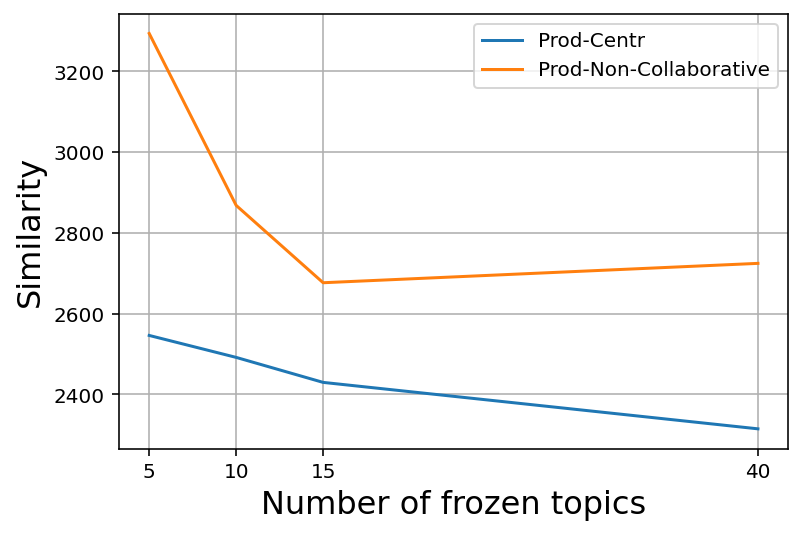

In [23]:
plt.semilogx(frozen_topics_list, sim_thetas_centralized, label="Prod-Centr", marker="x")
plt.semilogx(frozen_topics_list, sim_thetas_non_colab, label="Prod-Non-Collaborative", marker="x")
#plt.plot(frozen_topics_list, sim_thetas_baseline, label="Baseline")
plt.legend(loc="upper right")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Doc similarity score', fontsize=16)
plt.xticks(frozen_topics_list, [5,10,15,40])
plt.grid()
plt.show()

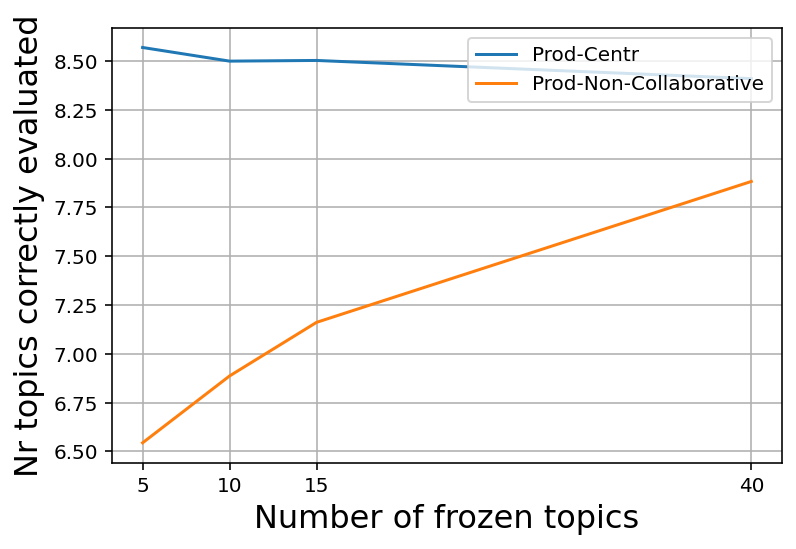

In [24]:
plt.plot(frozen_topics_list, sim_betas_centralized, label="Prod-Centr")
plt.plot(frozen_topics_list, sim_betas_non_colab, label="Prod-Non-Collaborative")
plt.legend(loc="upper right")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Topics correctly identified', fontsize=16)
plt.xticks(frozen_topics_list, [5,10,15,40])
plt.grid()
plt.show()

In [25]:
frozen_topics_list = [5,10,15,40]
eta_list = [1e-2, 0.02, 0.03, 0.04, 0.08, 1]

sim_betas_centralized = []
sim_thetas_centralized = []
sim_betas_non_colab = []
sim_thetas_non_colab = []

for eta in eta_list:
    print("Executing for eta equals to ", str(eta))
    
    tm_settings["beta"] = eta
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics_list[1] * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    # Generate documents
    topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)
    
    # Generate inference corpus and its docs_topics
    inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
    print("Length of the inference corpus ", str(len(inf)))

    for i in range(len(doc_topics_all)):
        if i == 0:
            inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
        else:
            inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
    print("Shape of inf_doc_topics", str(inf_doc_topics.shape))
    
    ########################
    # Centralized training #
    ########################
    print("CENTRALIZED")
    # Define corpus
    corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
    print("Size of centralized corpus ", str(len(corpus)))

    # Train model 
    modelname = "prod_centralized"
    modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)
    
    # Get betas
    betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
    betas = softmax(betas, axis=1)
    all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
    betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                            model=avitm,
                                            model_type="avitm",
                                            ntopics=n_topics,
                                            id2token=id2token,
                                            all_words=all_words)

    # Get thetas
    #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
    #thetas_theoretical = doc_topics_all[0][0:n_docs]

    # Eval betas and thetas
    betas_31 = eval_betas(betas, topic_vectors)
    #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
    sim_betas_centralized.append(betas_31)
    
    # Inference
    # Get inferred thetas
    docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    thetas_inf = np.asarray(avitm.get_thetas(val_data))#np.asarray(avitm.get_doc_topic_distribution(val_data))
    thetas_theoretical = inf_doc_topics

    # Eval thetas
    thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
    sim_thetas_centralized.append(thetas_312)
    
    #############################
    # Non-colaborative training #
    #############################
    betas_nodes = []
    thetas_nodes = []
    for node in range(n_nodes):
        print("NON-COLLABORATIVE of node ", str(node))
        # Define corpus
        corpus = documents_all[node][0:n_docs]
        print("Size of non-collaborative corpus ", str(len(corpus)))

        # Train model 
        modelname = "prodlda_node"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
        betas = softmax(betas, axis=1)
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
        #thetas_theoretical = doc_topics_all[0][0:n_docs]


        # Eval betas and thetas
        betas_32 = eval_betas(betas, topic_vectors)
        betas_nodes.append(betas_32)

        #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_thetas(val_data))#np.asarray(avitm.get_doc_topic_distribution(val_data))

        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        thetas_nodes.append(thetas_322)
    
    avg1 = sum(betas_nodes)/n_nodes
    avg2 = sum(thetas_nodes)/n_nodes
    sim_betas_non_colab.append(avg1)
    print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
    sim_thetas_non_colab.append(avg2)

Executing for eta equals to  0.01
Generating document words for node  0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.71it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.54it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.53it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 40.88it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.77it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1661.918875	Time: 0:00:00.431487
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1611.928678125	Time: 0:00:00.059181
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1545.0308875	Time: 0:00:00.422055
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1482.83561875	Time: 0:00:00.077948
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1504.6511020833334	Time: 0:00:00.420083
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1460.824390625	Time: 0:00:00.075642
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1486.5191760416667	Time: 0:00:00.412250
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1449.23605625	Time: 0:00:00.062407
Epoch: [5/100]	Samples: [18750

Epoch: [1/100]	Samples: [750/75000]	Train Loss: 1660.3941041666667	Time: 0:00:00.091337
Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1575.22696875	Time: 0:00:00.012171
Epoch: [2/100]	Samples: [1500/75000]	Train Loss: 1621.7773333333334	Time: 0:00:00.088860
Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1588.00378125	Time: 0:00:00.012309
Epoch: [3/100]	Samples: [2250/75000]	Train Loss: 1573.472	Time: 0:00:00.091559
Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1592.50896875	Time: 0:00:00.012106
Epoch: [4/100]	Samples: [3000/75000]	Train Loss: 1538.9836979166666	Time: 0:00:00.089648
Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1571.7765	Time: 0:00:00.012222
Epoch: [5/100]	Samples: [3750/75000]	Train Loss: 1508.2769166666667	Time: 0:00:00.089678
Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1536.337625	Time: 0:00:00.012083
Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1486.1121354166667	Time: 0:00:00.088073
Epoch: [6/100]	Samples: [250/25000]	Validat

Epoch: [23/100]	Samples: [17250/75000]	Train Loss: 1399.5378385416666	Time: 0:00:00.088218
Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1363.54796875	Time: 0:00:00.012435
Epoch: [24/100]	Samples: [18000/75000]	Train Loss: 1395.0648020833332	Time: 0:00:00.087142
Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1362.53109375	Time: 0:00:00.012544
Epoch: [25/100]	Samples: [18750/75000]	Train Loss: 1390.5323385416666	Time: 0:00:00.101774
Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1355.914625	Time: 0:00:00.015076
Epoch: [26/100]	Samples: [19500/75000]	Train Loss: 1391.880484375	Time: 0:00:00.089438
Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1359.64721875	Time: 0:00:00.012227
Epoch: [27/100]	Samples: [20250/75000]	Train Loss: 1391.92875	Time: 0:00:00.091361
Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1357.01753125	Time: 0:00:00.015376
Epoch: [28/100]	Samples: [21000/75000]	Train Loss: 1388.743109375	Time: 0:00:00.089529
Epoch: [28/100]	Samples: [2

Epoch: [23/100]	Samples: [17250/75000]	Train Loss: 1385.52175	Time: 0:00:00.090124
Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1344.277625	Time: 0:00:00.014772
Epoch: [24/100]	Samples: [18000/75000]	Train Loss: 1383.354578125	Time: 0:00:00.089152
Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1348.64371875	Time: 0:00:00.014659
Epoch: [25/100]	Samples: [18750/75000]	Train Loss: 1380.9956041666667	Time: 0:00:00.091031
Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1347.496625	Time: 0:00:00.012335
Epoch: [26/100]	Samples: [19500/75000]	Train Loss: 1380.3148385416666	Time: 0:00:00.086841
Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1343.59478125	Time: 0:00:00.012411
Epoch: [27/100]	Samples: [20250/75000]	Train Loss: 1380.2859322916668	Time: 0:00:00.086177
Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1345.37896875	Time: 0:00:00.012192
Epoch: [28/100]	Samples: [21000/75000]	Train Loss: 1376.61946875	Time: 0:00:00.088257
Epoch: [28/100]	Samples: [250/

Epoch: [37/100]	Samples: [27750/75000]	Train Loss: 1368.1661666666666	Time: 0:00:00.088159
Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1335.983875	Time: 0:00:00.012321
Epoch: [38/100]	Samples: [28500/75000]	Train Loss: 1365.18934375	Time: 0:00:00.087658
Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1332.64896875	Time: 0:00:00.014813
Epoch: [39/100]	Samples: [29250/75000]	Train Loss: 1369.9045833333332	Time: 0:00:00.090750
Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1329.1305625	Time: 0:00:00.012910
Epoch: [40/100]	Samples: [30000/75000]	Train Loss: 1365.8764791666667	Time: 0:00:00.091858
Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1333.9825	Time: 0:00:00.012256
Epoch: [41/100]	Samples: [30750/75000]	Train Loss: 1367.1751510416666	Time: 0:00:00.087981
Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1333.19353125	Time: 0:00:00.012478
Epoch: [42/100]	Samples: [31500/75000]	Train Loss: 1366.8305	Time: 0:00:00.089371
Epoch: [42/100]	Samples: [250/

Epoch: [14/100]	Samples: [10500/75000]	Train Loss: 1422.356375	Time: 0:00:00.088248
Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1376.3429375	Time: 0:00:00.012155
Epoch: [15/100]	Samples: [11250/75000]	Train Loss: 1419.4046041666666	Time: 0:00:00.089832
Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1368.47940625	Time: 0:00:00.014807
Epoch: [16/100]	Samples: [12000/75000]	Train Loss: 1406.3789791666666	Time: 0:00:00.090942
Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1368.145625	Time: 0:00:00.014959
Epoch: [17/100]	Samples: [12750/75000]	Train Loss: 1402.2508802083332	Time: 0:00:00.089533
Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1358.04353125	Time: 0:00:00.011961
Epoch: [18/100]	Samples: [13500/75000]	Train Loss: 1406.5926510416666	Time: 0:00:00.088422
Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1358.30634375	Time: 0:00:00.012130
Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1400.8625364583334	Time: 0:00:00.088811
Epoch: [19/100]	Sam

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.54it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:55<00:00, 36.03it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:55<00:00, 35.78it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:55<00:00, 35.86it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:55<00:00, 35.82it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1726.4901479166667	Time: 0:00:00.455330
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1663.02848125	Time: 0:00:00.061485
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1614.287684375	Time: 0:00:00.440262
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1550.854653125	Time: 0:00:00.060727
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1574.6043427083334	Time: 0:00:00.452854
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1524.81839375	Time: 0:00:00.058852
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1551.522684375	Time: 0:00:00.449553
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1512.203759375	Time: 0:00:00.077121
Epoch: [5/100]	Samples: [

Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1552.0727604166666	Time: 0:00:00.092477
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1536.551125	Time: 0:00:00.012859
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1542.9789166666667	Time: 0:00:00.093777
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1516.74525	Time: 0:00:00.012512
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1527.89565625	Time: 0:00:00.091668
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1509.10334375	Time: 0:00:00.015581
Epoch: [10/100]	Samples: [7500/75000]	Train Loss: 1515.7240208333333	Time: 0:00:00.094954
Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1499.9065625	Time: 0:00:00.012596
Epoch: [11/100]	Samples: [8250/75000]	Train Loss: 1516.2701458333333	Time: 0:00:00.092933
Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1493.10578125	Time: 0:00:00.015458
Epoch: [12/100]	Samples: [9000/75000]	Train Loss: 1502.81771875	Time: 0:00:00.094177
Epoch: [12/100]	Samples: [250/25000]	

Epoch: [17/100]	Samples: [12750/75000]	Train Loss: 1482.8194479166666	Time: 0:00:00.087623
Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1480.89265625	Time: 0:00:00.012815
Epoch: [18/100]	Samples: [13500/75000]	Train Loss: 1474.7712916666667	Time: 0:00:00.089652
Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1479.28325	Time: 0:00:00.012613
Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1477.3341041666667	Time: 0:00:00.086295
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1480.38240625	Time: 0:00:00.012763
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1473.5276666666666	Time: 0:00:00.086645
Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1469.752875	Time: 0:00:00.012587
Epoch: [21/100]	Samples: [15750/75000]	Train Loss: 1475.8100729166667	Time: 0:00:00.091255
Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1472.0383125	Time: 0:00:00.012726
Epoch: [22/100]	Samples: [16500/75000]	Train Loss: 1468.5973229166666	Time: 0:00:00.092338
Epoch: [22/100]

Epoch: [15/100]	Samples: [11250/75000]	Train Loss: 1521.3002916666667	Time: 0:00:00.090347
Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1476.27003125	Time: 0:00:00.012462
Epoch: [16/100]	Samples: [12000/75000]	Train Loss: 1520.0101979166666	Time: 0:00:00.087584
Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1479.16278125	Time: 0:00:00.012075
Epoch: [17/100]	Samples: [12750/75000]	Train Loss: 1517.9504479166667	Time: 0:00:00.085748
Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1470.45990625	Time: 0:00:00.012337
Epoch: [18/100]	Samples: [13500/75000]	Train Loss: 1509.66653125	Time: 0:00:00.088406
Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1472.91053125	Time: 0:00:00.014871
Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1512.2873541666668	Time: 0:00:00.088684
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1469.06078125	Time: 0:00:00.012386
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1507.9392916666666	Time: 0:00:00.085889
Epoch: [20/100

Epoch: [18/100]	Samples: [13500/75000]	Train Loss: 1491.58825	Time: 0:00:00.088894
Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1449.2229375	Time: 0:00:00.012507
Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1488.6694791666666	Time: 0:00:00.088661
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1441.8683125	Time: 0:00:00.012301
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1488.0365416666666	Time: 0:00:00.093391
Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1445.27203125	Time: 0:00:00.015598
Epoch: [21/100]	Samples: [15750/75000]	Train Loss: 1480.0659479166666	Time: 0:00:00.093975
Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1450.07275	Time: 0:00:00.014934
Epoch: [22/100]	Samples: [16500/75000]	Train Loss: 1480.6513854166667	Time: 0:00:00.096643
Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1440.5831875	Time: 0:00:00.012695
Epoch: [23/100]	Samples: [17250/75000]	Train Loss: 1481.748875	Time: 0:00:00.091079
Epoch: [23/100]	Samples: [250/

Epoch: [15/100]	Samples: [11250/75000]	Train Loss: 1499.7162291666666	Time: 0:00:00.089079
Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1456.22428125	Time: 0:00:00.012723
Epoch: [16/100]	Samples: [12000/75000]	Train Loss: 1494.1773229166668	Time: 0:00:00.090510
Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1456.123	Time: 0:00:00.012106
Epoch: [17/100]	Samples: [12750/75000]	Train Loss: 1489.5823645833334	Time: 0:00:00.085605
Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1455.54271875	Time: 0:00:00.012241
Epoch: [18/100]	Samples: [13500/75000]	Train Loss: 1492.07671875	Time: 0:00:00.087844
Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1452.18165625	Time: 0:00:00.012137
Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1488.1498333333334	Time: 0:00:00.087725
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1450.01784375	Time: 0:00:00.015088
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1480.9183645833334	Time: 0:00:00.089094
Epoch: [20/100]	Sam

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 35.05it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.21it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.30it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.84it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.30it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1757.312825	Time: 0:00:00.461030
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1702.099796875	Time: 0:00:00.062099
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1657.14185	Time: 0:00:00.454808
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1614.83	Time: 0:00:00.061585
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1614.7720489583332	Time: 0:00:00.455523
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1583.980696875	Time: 0:00:00.062032
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1591.6524104166667	Time: 0:00:00.456882
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1567.5440625	Time: 0:00:00.061331
Epoch: [5/100]	Samples: [18750/375000]	

Epoch: [13/100]	Samples: [9750/75000]	Train Loss: 1547.4382083333333	Time: 0:00:00.100967
Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1552.25809375	Time: 0:00:00.015519
Epoch: [14/100]	Samples: [10500/75000]	Train Loss: 1538.7460104166666	Time: 0:00:00.085488
Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1549.11603125	Time: 0:00:00.012616
Epoch: [15/100]	Samples: [11250/75000]	Train Loss: 1536.1281354166667	Time: 0:00:00.087716
Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1545.8115625	Time: 0:00:00.012826
Epoch: [16/100]	Samples: [12000/75000]	Train Loss: 1535.6643333333334	Time: 0:00:00.087560
Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1542.92621875	Time: 0:00:00.012620
Epoch: [17/100]	Samples: [12750/75000]	Train Loss: 1524.7964166666666	Time: 0:00:00.086402
Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1541.4295	Time: 0:00:00.013108
Epoch: [18/100]	Samples: [13500/75000]	Train Loss: 1524.5111770833332	Time: 0:00:00.085951
Epoch: [18/100]

Epoch: [33/100]	Samples: [24750/75000]	Train Loss: 1512.8543125	Time: 0:00:00.090892
Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1489.40171875	Time: 0:00:00.012451
Epoch: [34/100]	Samples: [25500/75000]	Train Loss: 1511.0090520833332	Time: 0:00:00.090020
Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1487.174125	Time: 0:00:00.012181
Epoch: [35/100]	Samples: [26250/75000]	Train Loss: 1510.6380520833334	Time: 0:00:00.088463
Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1486.68175	Time: 0:00:00.012486
Epoch: [36/100]	Samples: [27000/75000]	Train Loss: 1507.8781875	Time: 0:00:00.088991
Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1485.841875	Time: 0:00:00.012177
Epoch: [37/100]	Samples: [27750/75000]	Train Loss: 1506.634375	Time: 0:00:00.088295
Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1485.2583125	Time: 0:00:00.012816
Early stopping
Tópicos (equivalentes) evaluados correctamente:
13.234614343077254
Difference in evaluation of doc similarity:
2

Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1481.0975	Time: 0:00:00.013206
Epoch: [42/100]	Samples: [31500/75000]	Train Loss: 1497.9418020833334	Time: 0:00:00.087281
Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1475.823625	Time: 0:00:00.012426
Epoch: [43/100]	Samples: [32250/75000]	Train Loss: 1500.301390625	Time: 0:00:00.086851
Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1475.90921875	Time: 0:00:00.013072
Early stopping
Tópicos (equivalentes) evaluados correctamente:
13.27122513505293
Difference in evaluation of doc similarity:
2288.2382743164762
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Epoch: [1/100]	Samples: [750/75000]	Train Loss: 1771.89503125	Time: 0:00:00.086190
Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1622.84021875	Time: 0:00:00.012199
Epoch: [2/100]	Samples: [1500/75000]	Tra

Epoch: [43/100]	Samples: [32250/75000]	Train Loss: 1500.9651979166667	Time: 0:00:00.086149
Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1459.1114375	Time: 0:00:00.012732
Epoch: [44/100]	Samples: [33000/75000]	Train Loss: 1500.9369375	Time: 0:00:00.083770
Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1461.666125	Time: 0:00:00.012231
Epoch: [45/100]	Samples: [33750/75000]	Train Loss: 1505.0481458333334	Time: 0:00:00.089491
Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1463.43784375	Time: 0:00:00.012438
Epoch: [46/100]	Samples: [34500/75000]	Train Loss: 1505.9027604166668	Time: 0:00:00.083819
Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1462.2928125	Time: 0:00:00.012038
Epoch: [47/100]	Samples: [35250/75000]	Train Loss: 1503.1745104166666	Time: 0:00:00.085605
Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1462.82678125	Time: 0:00:00.013017
Epoch: [48/100]	Samples: [36000/75000]	Train Loss: 1500.8227708333334	Time: 0:00:00.084390
Epoch: [48/100]	Sam

Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1490.32978125	Time: 0:00:00.014415
Epoch: [40/100]	Samples: [30000/75000]	Train Loss: 1498.2565833333333	Time: 0:00:00.083381
Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1490.64984375	Time: 0:00:00.012242
Epoch: [41/100]	Samples: [30750/75000]	Train Loss: 1493.7924895833332	Time: 0:00:00.084509
Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1489.777375	Time: 0:00:00.012360
Epoch: [42/100]	Samples: [31500/75000]	Train Loss: 1491.658625	Time: 0:00:00.082783
Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1489.7679375	Time: 0:00:00.012133
Epoch: [43/100]	Samples: [32250/75000]	Train Loss: 1490.5809479166667	Time: 0:00:00.083427
Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1488.9830625	Time: 0:00:00.012445
Epoch: [44/100]	Samples: [33000/75000]	Train Loss: 1493.7775208333333	Time: 0:00:00.083521
Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1485.8436875	Time: 0:00:00.012096
Epoch: [45/100]	Samples

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.82it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 35.01it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.93it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.86it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.81it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1771.37105	Time: 0:00:00.462871
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1718.92275	Time: 0:00:00.079516
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1681.7371760416668	Time: 0:00:00.468186
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1646.642353125	Time: 0:00:00.062232
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1638.7904416666668	Time: 0:00:00.467891
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1615.627196875	Time: 0:00:00.062393
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1615.3104875	Time: 0:00:00.464020
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1599.8172125	Time: 0:00:00.062706
Epoch: [5/100]	Samples: [18750/3750

Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1629.7915625	Time: 0:00:00.238717
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1589.057875	Time: 0:00:00.012944
Epoch: [10/100]	Samples: [7500/75000]	Train Loss: 1619.2229270833334	Time: 0:00:00.098673
Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1569.17375	Time: 0:00:00.015811
Epoch: [11/100]	Samples: [8250/75000]	Train Loss: 1610.1208229166666	Time: 0:00:00.105025
Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1567.0444375	Time: 0:00:00.016028
Epoch: [12/100]	Samples: [9000/75000]	Train Loss: 1595.4068333333332	Time: 0:00:00.106470
Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1560.042125	Time: 0:00:00.016814
Epoch: [13/100]	Samples: [9750/75000]	Train Loss: 1595.1064166666667	Time: 0:00:00.098547
Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1550.28140625	Time: 0:00:00.012773
Epoch: [14/100]	Samples: [10500/75000]	Train Loss: 1590.1363229166666	Time: 0:00:00.104458
Epoch: [14/100]	Samples: [250/

Epoch: [5/100]	Samples: [3750/75000]	Train Loss: 1688.3565208333334	Time: 0:00:00.093857
Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1655.31171875	Time: 0:00:00.013110
Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1671.5216979166667	Time: 0:00:00.086940
Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1627.8594375	Time: 0:00:00.012632
Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1652.4687291666667	Time: 0:00:00.091208
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1609.0580625	Time: 0:00:00.015865
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1635.3984583333333	Time: 0:00:00.089664
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1592.23084375	Time: 0:00:00.012703
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1627.1002395833334	Time: 0:00:00.093056
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1581.0385	Time: 0:00:00.012796
Epoch: [10/100]	Samples: [7500/75000]	Train Loss: 1612.8683020833334	Time: 0:00:00.093553
Epoch: [10/100]	Samples: [250/2

Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1564.3858020833334	Time: 0:00:00.085792
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1538.82028125	Time: 0:00:00.013188
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1565.1237083333333	Time: 0:00:00.090517
Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1537.483	Time: 0:00:00.012796
Epoch: [21/100]	Samples: [15750/75000]	Train Loss: 1566.9943541666667	Time: 0:00:00.094482
Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1538.136	Time: 0:00:00.013163
Epoch: [22/100]	Samples: [16500/75000]	Train Loss: 1554.9808125	Time: 0:00:00.089739
Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1537.78375	Time: 0:00:00.012815
Epoch: [23/100]	Samples: [17250/75000]	Train Loss: 1555.0480520833332	Time: 0:00:00.087434
Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1534.8286875	Time: 0:00:00.012769
Epoch: [24/100]	Samples: [18000/75000]	Train Loss: 1549.5873020833333	Time: 0:00:00.086822
Epoch: [24/100]	Samples: [250

Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1553.33384375	Time: 0:00:00.091291
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1551.484875	Time: 0:00:00.013248
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1551.4522708333334	Time: 0:00:00.093746
Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1549.9939375	Time: 0:00:00.013252
Epoch: [21/100]	Samples: [15750/75000]	Train Loss: 1550.6826875	Time: 0:00:00.090938
Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1547.266	Time: 0:00:00.013137
Epoch: [22/100]	Samples: [16500/75000]	Train Loss: 1543.362875	Time: 0:00:00.092285
Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1545.8848125	Time: 0:00:00.013077
Epoch: [23/100]	Samples: [17250/75000]	Train Loss: 1544.0373020833333	Time: 0:00:00.091579
Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1544.23778125	Time: 0:00:00.013300
Epoch: [24/100]	Samples: [18000/75000]	Train Loss: 1539.94121875	Time: 0:00:00.092324
Epoch: [24/100]	Samples: [250/25000]	Vali

Epoch: [12/100]	Samples: [9000/75000]	Train Loss: 1587.5662604166666	Time: 0:00:00.084581
Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1572.611625	Time: 0:00:00.013132
Epoch: [13/100]	Samples: [9750/75000]	Train Loss: 1584.54578125	Time: 0:00:00.084501
Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1564.8116875	Time: 0:00:00.012859
Epoch: [14/100]	Samples: [10500/75000]	Train Loss: 1581.9595104166667	Time: 0:00:00.090310
Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1567.50778125	Time: 0:00:00.013173
Epoch: [15/100]	Samples: [11250/75000]	Train Loss: 1576.7127916666666	Time: 0:00:00.088270
Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1561.10725	Time: 0:00:00.012802
Epoch: [16/100]	Samples: [12000/75000]	Train Loss: 1566.8663854166666	Time: 0:00:00.088826
Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1558.07003125	Time: 0:00:00.012966
Epoch: [17/100]	Samples: [12750/75000]	Train Loss: 1562.2386145833334	Time: 0:00:00.089841
Epoch: [17/100]	Sample

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.90it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.27it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.12it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.87it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.03it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1798.2721520833334	Time: 0:00:00.449375
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1702.363534375	Time: 0:00:00.061614
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1732.3134041666667	Time: 0:00:00.441534
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1672.002603125	Time: 0:00:00.062204
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1688.0515385416666	Time: 0:00:00.446086
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1642.160709375	Time: 0:00:00.062534
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1661.589390625	Time: 0:00:00.443977
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1624.494984375	Time: 0:00:00.062869
Epoch: [5/100]	Samp

Epoch: [45/100]	Samples: [168750/375000]	Train Loss: 1588.4388197916667	Time: 0:00:00.444121
Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1569.068725	Time: 0:00:00.071990
Epoch: [46/100]	Samples: [172500/375000]	Train Loss: 1588.3953416666666	Time: 0:00:00.443497
Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1569.36701875	Time: 0:00:00.064670
Epoch: [47/100]	Samples: [176250/375000]	Train Loss: 1587.9082020833334	Time: 0:00:00.446821
Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1568.64375	Time: 0:00:00.063392
Epoch: [48/100]	Samples: [180000/375000]	Train Loss: 1587.135496875	Time: 0:00:00.440481
Epoch: [48/100]	Samples: [1250/125000]	Validation Loss: 1571.3181625	Time: 0:00:00.064399
Epoch: [49/100]	Samples: [183750/375000]	Train Loss: 1587.2908583333333	Time: 0:00:00.446315
Epoch: [49/100]	Samples: [1250/125000]	Validation Loss: 1569.3883375	Time: 0:00:00.063977
Epoch: [50/100]	Samples: [187500/375000]	Train Loss: 1587.4054458333333	Time: 0:00:00.44359

Epoch: [19/100]	Samples: [14250/75000]	Train Loss: 1628.1848020833334	Time: 0:00:00.095387
Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1628.462625	Time: 0:00:00.013750
Epoch: [20/100]	Samples: [15000/75000]	Train Loss: 1624.0421666666666	Time: 0:00:00.094616
Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1625.7174375	Time: 0:00:00.016309
Epoch: [21/100]	Samples: [15750/75000]	Train Loss: 1621.1073541666667	Time: 0:00:00.092531
Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1622.709125	Time: 0:00:00.013832
Epoch: [22/100]	Samples: [16500/75000]	Train Loss: 1620.2512291666667	Time: 0:00:00.094630
Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1619.71434375	Time: 0:00:00.013688
Epoch: [23/100]	Samples: [17250/75000]	Train Loss: 1612.9466041666667	Time: 0:00:00.093052
Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1619.2754375	Time: 0:00:00.014102
Epoch: [24/100]	Samples: [18000/75000]	Train Loss: 1610.2793020833333	Time: 0:00:00.092781
Epoch: [24/100]

Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1675.23925	Time: 0:00:00.094288
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1678.1246875	Time: 0:00:00.016570
Epoch: [10/100]	Samples: [7500/75000]	Train Loss: 1667.1276875	Time: 0:00:00.092808
Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1667.29578125	Time: 0:00:00.016156
Epoch: [11/100]	Samples: [8250/75000]	Train Loss: 1658.9000416666668	Time: 0:00:00.092823
Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1663.7214375	Time: 0:00:00.013339
Epoch: [12/100]	Samples: [9000/75000]	Train Loss: 1648.3488958333332	Time: 0:00:00.105310
Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1655.671125	Time: 0:00:00.016232
Epoch: [13/100]	Samples: [9750/75000]	Train Loss: 1643.286875	Time: 0:00:00.105186
Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1648.5734375	Time: 0:00:00.014935
Epoch: [14/100]	Samples: [10500/75000]	Train Loss: 1634.594	Time: 0:00:00.092377
Epoch: [14/100]	Samples: [250/25000]	Validation Loss

Epoch: [5/100]	Samples: [3750/75000]	Train Loss: 1766.3941354166666	Time: 0:00:00.097681
Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1680.7298125	Time: 0:00:00.013735
Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1748.0831354166667	Time: 0:00:00.095598
Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1673.56284375	Time: 0:00:00.016258
Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1731.2819270833334	Time: 0:00:00.094699
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1663.75371875	Time: 0:00:00.013447
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1717.6927395833334	Time: 0:00:00.092698
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1656.9601875	Time: 0:00:00.016306
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1705.37015625	Time: 0:00:00.094140
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1653.404625	Time: 0:00:00.016657
Epoch: [10/100]	Samples: [7500/75000]	Train Loss: 1696.3579895833334	Time: 0:00:00.095110
Epoch: [10/100]	Samples: [250/2500

Epoch: [52/100]	Samples: [39000/75000]	Train Loss: 1593.87753125	Time: 0:00:00.093531
Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1576.63109375	Time: 0:00:00.013997
Epoch: [53/100]	Samples: [39750/75000]	Train Loss: 1590.9365208333334	Time: 0:00:00.091084
Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1576.52028125	Time: 0:00:00.013541
Epoch: [54/100]	Samples: [40500/75000]	Train Loss: 1591.46728125	Time: 0:00:00.091345
Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1576.65925	Time: 0:00:00.014130
Epoch: [55/100]	Samples: [41250/75000]	Train Loss: 1591.95890625	Time: 0:00:00.091266
Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1576.8241875	Time: 0:00:00.013642
Epoch: [56/100]	Samples: [42000/75000]	Train Loss: 1591.3839270833334	Time: 0:00:00.093859
Epoch: [56/100]	Samples: [250/25000]	Validation Loss: 1576.36225	Time: 0:00:00.014114
Epoch: [57/100]	Samples: [42750/75000]	Train Loss: 1590.1782291666666	Time: 0:00:00.091499
Epoch: [57/100]	Samples: [250/2

Epoch: [33/100]	Samples: [24750/75000]	Train Loss: 1592.7927291666667	Time: 0:00:00.095168
Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1601.95125	Time: 0:00:00.013571
Epoch: [34/100]	Samples: [25500/75000]	Train Loss: 1590.5989791666666	Time: 0:00:00.096865
Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1604.111	Time: 0:00:00.013683
Epoch: [35/100]	Samples: [26250/75000]	Train Loss: 1587.8552083333334	Time: 0:00:00.095951
Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1599.69896875	Time: 0:00:00.013668
Epoch: [36/100]	Samples: [27000/75000]	Train Loss: 1585.35046875	Time: 0:00:00.093556
Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1600.75403125	Time: 0:00:00.013788
Epoch: [37/100]	Samples: [27750/75000]	Train Loss: 1584.4065520833333	Time: 0:00:00.093346
Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1598.1785	Time: 0:00:00.016688
Epoch: [38/100]	Samples: [28500/75000]	Train Loss: 1582.4436875	Time: 0:00:00.094054
Epoch: [38/100]	Samples: [250/25

Epoch: [25/100]	Samples: [18750/75000]	Train Loss: 1611.36790625	Time: 0:00:00.093396
Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1608.1931875	Time: 0:00:00.013716
Epoch: [26/100]	Samples: [19500/75000]	Train Loss: 1608.9914791666667	Time: 0:00:00.092679
Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1611.55825	Time: 0:00:00.016274
Epoch: [27/100]	Samples: [20250/75000]	Train Loss: 1607.0019166666666	Time: 0:00:00.095186
Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1607.56821875	Time: 0:00:00.013859
Epoch: [28/100]	Samples: [21000/75000]	Train Loss: 1603.6108125	Time: 0:00:00.099537
Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1608.524375	Time: 0:00:00.014472
Epoch: [29/100]	Samples: [21750/75000]	Train Loss: 1603.5864895833333	Time: 0:00:00.091511
Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1608.66765625	Time: 0:00:00.013789
Epoch: [30/100]	Samples: [22500/75000]	Train Loss: 1604.8293020833332	Time: 0:00:00.089442
Epoch: [30/100]	Samples: [

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.08it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 33.95it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 33.98it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.01it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.89it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [3750/375000]	Train Loss: 1808.0175645833333	Time: 0:00:00.446435
Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1698.13838125	Time: 0:00:00.061700
Epoch: [2/100]	Samples: [7500/375000]	Train Loss: 1798.1586770833333	Time: 0:00:00.453661
Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1711.1773625	Time: 0:00:00.063824
Epoch: [3/100]	Samples: [11250/375000]	Train Loss: 1792.4930958333334	Time: 0:00:00.445132
Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1711.167309375	Time: 0:00:00.061090
Epoch: [4/100]	Samples: [15000/375000]	Train Loss: 1785.2791979166666	Time: 0:00:00.442391
Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1711.1557375	Time: 0:00:00.062900
Epoch: [5/100]	Sampl

Epoch: [5/100]	Samples: [3750/75000]	Train Loss: 1806.4523541666667	Time: 0:00:00.090851
Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1672.88384375	Time: 0:00:00.016553
Epoch: [6/100]	Samples: [4500/75000]	Train Loss: 1801.5578854166667	Time: 0:00:00.093777
Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1675.43675	Time: 0:00:00.013465
Epoch: [7/100]	Samples: [5250/75000]	Train Loss: 1800.5143541666666	Time: 0:00:00.092256
Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1681.5599375	Time: 0:00:00.013775
Epoch: [8/100]	Samples: [6000/75000]	Train Loss: 1796.60896875	Time: 0:00:00.091299
Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1684.70225	Time: 0:00:00.016322
Epoch: [9/100]	Samples: [6750/75000]	Train Loss: 1791.8443958333332	Time: 0:00:00.094345
Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1685.4956875	Time: 0:00:00.013572
Early stopping
Tópicos (equivalentes) evaluados correctamente:
44.29288420999656
Difference in evaluation of doc similarity:
348

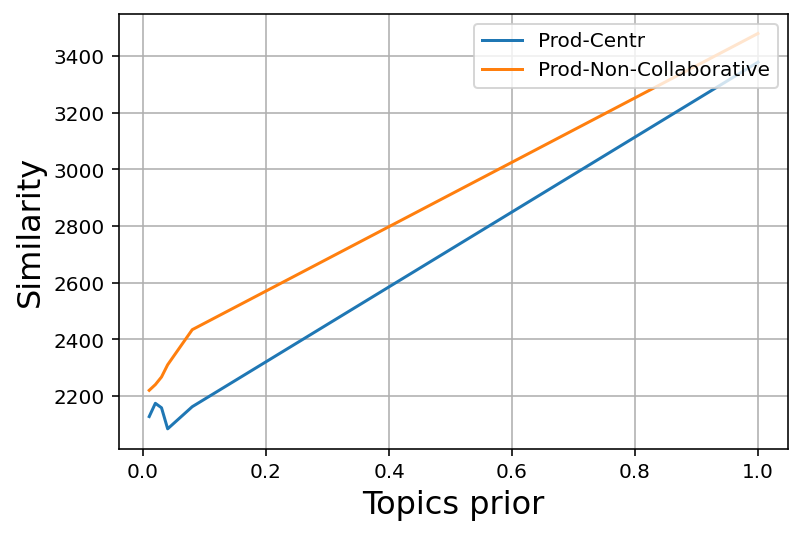

In [26]:
plt.plot(eta_list, sim_thetas_centralized, label="Prod-Centr")
plt.plot(eta_list, sim_thetas_non_colab, label="Prod-Non-Collaborative")
plt.legend(loc="upper right")

plt.xlabel(r'$\\eta$', fontsize=16)
plt.ylabel('Doc similarity score', fontsize=16)
#plt.xticks(eta_list, [1e-2, 0.02, 0.03, 0.04, 0.08, 1])
plt.grid()
plt.show()

In [27]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

[7.48790820163805, 11.52863365367631, 14.458031268828853, 16.584951307589545, 22.65822185012252, 44.292885402499884]
[6.231895270231613, 10.11865646112027, 13.239466144009715, 15.49068452383763, 22.275079302328127, 44.29288415720457]


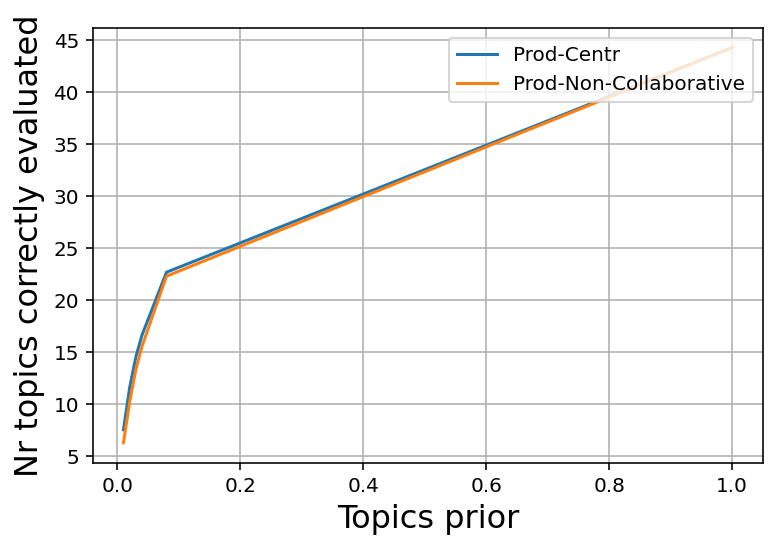

In [28]:
plt.plot(eta_list, sim_betas_centralized, label="Prod-Centr")
plt.plot(eta_list, sim_betas_non_colab, label="Prod-Non-Collaborative")
plt.legend(loc="upper right")

plt.xlabel('Topics prior', fontsize=16)
plt.ylabel('Nr topics correctly evaluated', fontsize=16)
#plt.xticks(eta_list, [1e-2, 0.02, 0.03, 0.04, 0.08, 1])
plt.grid()
plt.show()